In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from rdkit import Chem
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.covariance import EllipticEnvelope
from umap import UMAP
from dl4thermo.extras.utils import compute_morgan_fingerprints
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import molplotly
from pathlib import Path
import pandas as pd
import numpy as np
from numpy.random import default_rng
import seaborn as sns
from IPython.display import display
from tqdm import tqdm
from collections import Counter

In [6]:
%load_ext kedro.extras.extensions.ipython
%reload_kedro

The kedro.extras.extensions.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.extras.extensions.ipython


## SMILES resolution

In [4]:
df = catalog.load("pcp_saft_fitted_pure_parameters")

2022-12-07 10:11:05,535 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_fitted_pure_parameters' (CSVDataSet)...


In [5]:
df_clean = df.dropna(subset="Smiles").reset_index(drop=True)
no_resolve = df[df["Smiles"].isna()]
print(f"Total number of molecules: {len(df_clean)}")
print(f"{(1-len(no_resolve)/len(df))*100:.0f}% resolved")
df_include = df_clean #[df_clean["status"]=="Include"]


Total number of molecules: 1258
100% resolved


In [6]:
not_ions = df_include[~df_include["Smiles"].str.contains("(\+|\-)", regex=True)]
print(f"Trainable molecules (non-ionic, organic): {len(not_ions)/len(df_include)*100:.0f}% ({len(not_ions)})")

2022-12-07 10:11:37,798 - py.warnings - WARNING - <>:1: DeprecationWarning: invalid escape sequence \+

2022-12-07 10:11:37,799 - py.warnings - WARNING - <>:1: DeprecationWarning: invalid escape sequence \+

2022-12-07 10:11:37,874 - py.warnings - WARNING - /tmp/jr629406/login18-x-1_117671/ipykernel_132133/2180186038.py:1: DeprecationWarning: invalid escape sequence \+
  not_ions = df_include[~df_include["Smiles"].str.contains("(\+|\-)", regex=True)]

2022-12-07 10:11:37,876 - py.warnings - WARNING - /tmp/jr629406/login18-x-1_117671/ipykernel_132133/2180186038.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  not_ions = df_include[~df_include["Smiles"].str.contains("(\+|\-)", regex=True)]

Trainable molecules (non-ionic, organic): 96% (1208)


## Exploratory analysis of processed data

In [1]:
pure = catalog.load("pcp_saft_sepp_pure_parameters")
for col in ["KAB", "epsilonAB"]:
    pure[col] = pure[col].fillna(0)

2023-03-13 15:13:03,069 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_sepp_pure_parameters' (CSVDataSet)...


In [13]:
regressed_parameters = catalog.load("pcp_saft_regressed_pure_parameters_filtered")
split_idx = catalog.load("pcp_saft_regressed_pure_parameters_split_idx")

2023-03-13 15:22:06,680 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_regressed_pure_parameters_filtered' (CSVDataSet)...
2023-03-13 15:22:06,693 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_regressed_pure_parameters_split_idx' (PartitionedDataSet)...


In [17]:
regressed_smiles = set(regressed_parameters.iloc[split_idx["test_idx"]()].smiles_1)
sepp_smiles = set(pure.smiles)
inti = regressed_smiles.intersection(sepp_smiles)

In [11]:
atom_types = Counter()
all_smiles = pure["smiles"].tolist()
for smiles in all_smiles:
    mol = Chem.rdmolfiles.MolFromSmiles(smiles)  # type: ignore
    for atom in mol.GetAtoms():
        atom_type = atom.GetSymbol()
        atom_types[atom_type] += 1
atom_types

Counter({'C': 7073, 'N': 571, 'O': 1295, 'S': 20})

In [6]:
dortmund = catalog.load("dortmund_base_pure_component_filtered")

2023-02-25 23:47:56,592 - kedro.io.data_catalog - INFO - Loading data from 'dortmund_base_pure_component_filtered' (ParquetDataSet)...


In [11]:
atom_types = Counter()
all_smiles = dortmund["smiles_1"].unique().tolist()
for smiles in tqdm(all_smiles):
    mol = Chem.rdmolfiles.MolFromSmiles(smiles)  # type: ignore
    for atom in mol.GetAtoms():
        atom_type = atom.GetSymbol()
        atom_types[atom_type] += 1
atom_types

  9%|██████▎                                                                  | 1459/16953 [00:02<00:25, 597.73it/s][23:48:36] WARNING: not removing hydrogen atom without neighbors
[23:48:36] WARNING: not removing hydrogen atom without neighbors
100%|████████████████████████████████████████████████████████████████████████| 16953/16953 [00:29<00:00, 582.49it/s]


Counter({'C': 184138, 'O': 24745, 'N': 5101, 'F': 8533, 'S': 1530, 'H': 284, 'P': 455, 'I': 257})

In [12]:
accepted_atoms = ["C", "N", "O", "F"]
n_good = 0
for smiles in tqdm(all_smiles):
    mol = Chem.MolFromSmiles(smiles)
    good = True
    for atom in mol.GetAtoms():
        if atom.GetSymbol() not in accepted_atoms:
            good = False
    if good:
        n_good +=1
n_good

  9%|██████▎                                                                  | 1455/16953 [00:02<00:25, 596.17it/s][23:51:50] WARNING: not removing hydrogen atom without neighbors
[23:51:50] WARNING: not removing hydrogen atom without neighbors
100%|████████████████████████████████████████████████████████████████████████| 16953/16953 [00:28<00:00, 587.37it/s]


15141

In [14]:
len(all_smiles) - n_good

1812

#### Helper functions

In [36]:
def get_prop_statistics(target_prop_list):
    mean = np.asarray(target_prop_list).mean()
    stdev = np.asarray(target_prop_list).std()
    return mean, stdev

def get_outliers(smiles_list, target_prop_list, mean, stdev):
    outliers = {}
    for i in range(1,5):
        tmp_lower_bound = mean - i * stdev
        tmp_upper_bound = mean + i * stdev
        tmp_lower_outliers = []
        tmp_upper_outliers = []
        for s_idx, smi in enumerate(smiles_list):
            if target_prop_list[s_idx] < tmp_lower_bound: tmp_lower_outliers.append(smi)
            if target_prop_list[s_idx] > tmp_upper_bound: tmp_upper_outliers.append(smi)
        
        outliers[f"mean-{i}*stdev ({tmp_lower_bound})"] = tmp_lower_outliers
        outliers[f"mean+{i}*stdev ({tmp_upper_bound})"] = tmp_upper_outliers
    
    return outliers

def plot_all_values(smiles_list, target_prop_list, color, t):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,5))
    plt.bar([i for i in range(len(smiles_list))],target_prop_list, color=color, align='center')
    plt.xlabel("Mol id")
    plt.ylabel(t)
    plt.show()
    

#### Statistic and outliers for target properties



Target property: sigma

Mean 3.658, stdev 0.200

mean-1*stdev (3.45876512487753) -> #mols : 163
mean+1*stdev (3.8578051917612752) -> #mols : 163
mean-2*stdev (3.259245091435657) -> #mols : 47
mean+2*stdev (4.057325225203148) -> #mols : 2, outliers: ['CC(C)(C)C1CCCC1', 'C1CCCCNCCC1']
mean-3*stdev (3.0597250579937842) -> #mols : 16
mean+3*stdev (4.256845258645021) -> #mols : 0, outliers: []
mean-4*stdev (2.8602050245519117) -> #mols : 7, outliers: ['N#N', '[C-]#[O+]', 'NO', 'OO', '[N-]=[N+]=O', 'O=[O+][O-]', 'O=C=O']
mean+4*stdev (4.456365292086893) -> #mols : 0, outliers: []


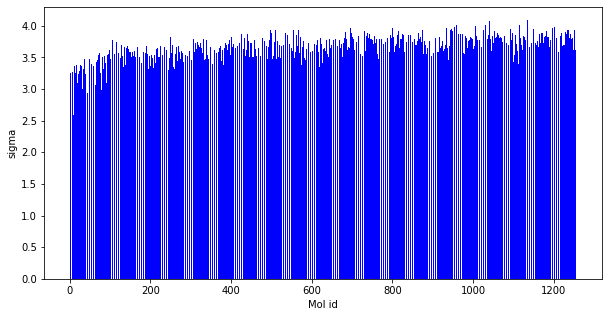



Target property: m

Mean 3.169, stdev 0.542

mean-1*stdev (2.626963062406565) -> #mols : 177
mean+1*stdev (3.71129459032215) -> #mols : 215
mean-2*stdev (2.0847972984487724) -> #mols : 34
mean+2*stdev (4.253460354279943) -> #mols : 30
mean-3*stdev (1.5426315344909798) -> #mols : 4, outliers: ['C#C', 'N#N', 'C#N', '[C-]#[O+]']
mean+3*stdev (4.7956261182377355) -> #mols : 0, outliers: []
mean-4*stdev (1.0004657705331872) -> #mols : 0, outliers: []
mean+4*stdev (5.337791882195528) -> #mols : 0, outliers: []


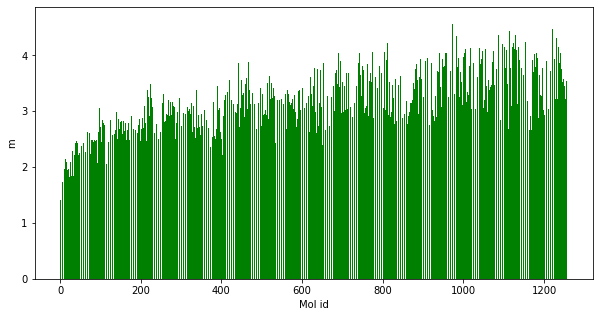



Target property: epsilon_k

Mean 285.727, stdev 68.211

mean-1*stdev (217.51558080388338) -> #mols : 58
mean+1*stdev (353.93766626414856) -> #mols : 158
mean-2*stdev (149.3045380737508) -> #mols : 1, outliers: ['C#C']
mean+2*stdev (422.14870899428115) -> #mols : 47
mean-3*stdev (81.0934953436182) -> #mols : 0, outliers: []
mean+3*stdev (490.35975172441374) -> #mols : 8, outliers: ['O=[N+]([O-])[N+](=O)[O-]', 'NC1=CC(=O)N=N1', 'CCC[NH3+].O=[N+]([O-])[O-]', 'Nc1ccnc(=O)[nH]1', 'CC(=O)CCCC(=O)O', 'C=CCCCC.[O]O[O-]', 'C1=CCCCC1.[O]O[O-]', 'Cn1ccc(N)nc1=O']
mean-4*stdev (12.882452613485611) -> #mols : 0, outliers: []
mean+4*stdev (558.5707944545463) -> #mols : 6, outliers: ['NC1=CC(=O)N=N1', 'CCC[NH3+].O=[N+]([O-])[O-]', 'Nc1ccnc(=O)[nH]1', 'C=CCCCC.[O]O[O-]', 'C1=CCCCC1.[O]O[O-]', 'Cn1ccc(N)nc1=O']


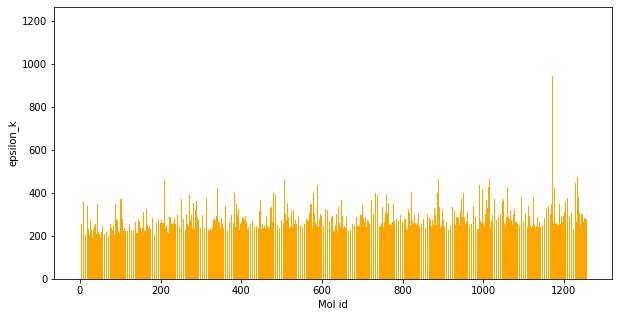



Target property: mu

Mean 3.864, stdev 45.225

mean-1*stdev (-41.36133819689893) -> #mols : 0, outliers: []
mean+1*stdev (49.08952616086633) -> #mols : 2, outliers: ['C=C=O', 'CN(C)N(C)C']
mean-2*stdev (-86.58677037578155) -> #mols : 0, outliers: []
mean+2*stdev (94.31495833974896) -> #mols : 2, outliers: ['C=C=O', 'CN(C)N(C)C']
mean-3*stdev (-131.8122025546642) -> #mols : 0, outliers: []
mean+3*stdev (139.5403905186316) -> #mols : 2, outliers: ['C=C=O', 'CN(C)N(C)C']
mean-4*stdev (-177.0376347335468) -> #mols : 0, outliers: []
mean+4*stdev (184.7658226975142) -> #mols : 2, outliers: ['C=C=O', 'CN(C)N(C)C']


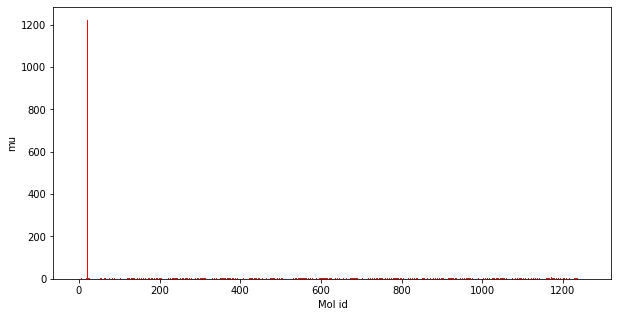



Target property: KAB

Mean nan, stdev nan

mean-1*stdev (nan) -> #mols : 0, outliers: []
mean+1*stdev (nan) -> #mols : 0, outliers: []
mean-2*stdev (nan) -> #mols : 0, outliers: []
mean+2*stdev (nan) -> #mols : 0, outliers: []
mean-3*stdev (nan) -> #mols : 0, outliers: []
mean+3*stdev (nan) -> #mols : 0, outliers: []
mean-4*stdev (nan) -> #mols : 0, outliers: []
mean+4*stdev (nan) -> #mols : 0, outliers: []


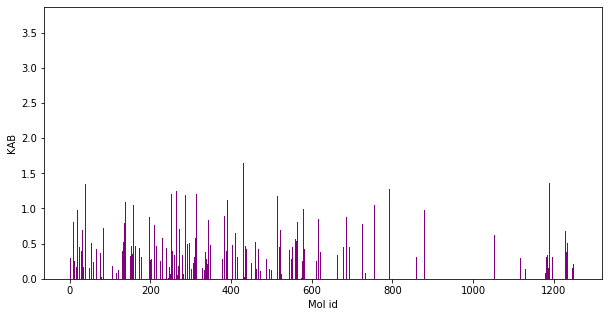



Target property: epsilonAB

Mean nan, stdev nan

mean-1*stdev (nan) -> #mols : 0, outliers: []
mean+1*stdev (nan) -> #mols : 0, outliers: []
mean-2*stdev (nan) -> #mols : 0, outliers: []
mean+2*stdev (nan) -> #mols : 0, outliers: []
mean-3*stdev (nan) -> #mols : 0, outliers: []
mean+3*stdev (nan) -> #mols : 0, outliers: []
mean-4*stdev (nan) -> #mols : 0, outliers: []
mean+4*stdev (nan) -> #mols : 0, outliers: []


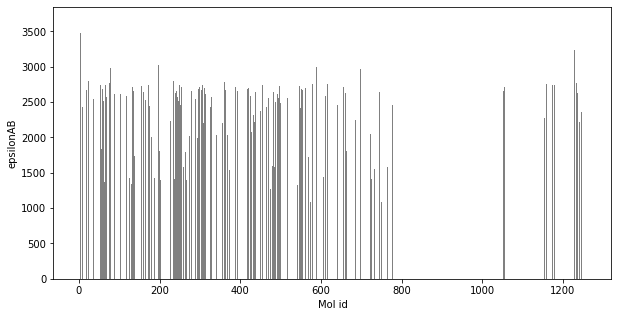

In [37]:
colors = ["blue", "green", "orange", "red", "purple", "grey"]
target_prop_names = ["sigma", "m", "epsilon_k", "mu", "KAB", "epsilonAB"]
for j, t in enumerate(target_prop_names):
    smiles_list = pure["Smiles"].tolist()
    target_prop_list = pure[t].tolist()
    mean, stdev = get_prop_statistics(target_prop_list)
    outliers = get_outliers(smiles_list, target_prop_list, mean, stdev)
    print(f"\n\nTarget property: {t}")
    print(f"\nMean {mean:.3f}, stdev {stdev:.3f}\n")
    for k, v in outliers.items():
        if len(v) < 10: 
            print(f"{k} -> #mols : {len(v)}, outliers: {v}")
        else: 
            print(f"{k} -> #mols : {len(v)}")
    plot_all_values(smiles_list, target_prop_list, colors[j], t)

In [21]:
output_columns = ['m', 'sigma', 'epsilon_k', "mu",'KAB', 'epsilonAB' ]
for col in output_columns:
    pure[col] = pure[col].astype(float)

In [23]:
means = pure[output_columns].mean()
stds = pure[output_columns].std()
df_norm = pure.copy()

for col in output_columns:
    df_norm[col] = (pure[col] - means[col])/stds[col]
    df_norm = df_norm[df_norm[col].abs()<2]
    
# preds = EllipticEnvelope(random_state=0).fit_predict(df_norm[output_columns])
# df_norm["outlier"] = preds
# df_norm["outlier"] = df_norm["outlier"].replace({1: "inlier", -1: "outlier"})
# pure_filt = pure.copy().loc[df_norm.index]
# pure_filt["outlier"] = df_norm["outlier"]
# df_norm["outlier"].value_counts()

In [24]:
morgans = compute_morgan_fingerprints(pure["Smiles"])
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(morgans)
pure["cluster"] = kmeans.labels_ + 1
pure_filt["cluster"] = pure.loc[df_norm.index, "cluster"]

morgan fingerprints: 100%|███████████████████████████████████| 1258/1258 [00:00<00:00, 14151.21it/s]

2023-01-17 14:32:10,816 - py.warnings - WARNING - /Users/Kobi/Library/Caches/pypoetry/virtualenvs/dl4thermo-gYF7kwgA-py3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



2023-01-17 14:32:14,900 - py.warnings - WARNING - /Users/Kobi/Library/Caches/pypoetry/virtualenvs/dl4thermo-gYF7kwgA-py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):



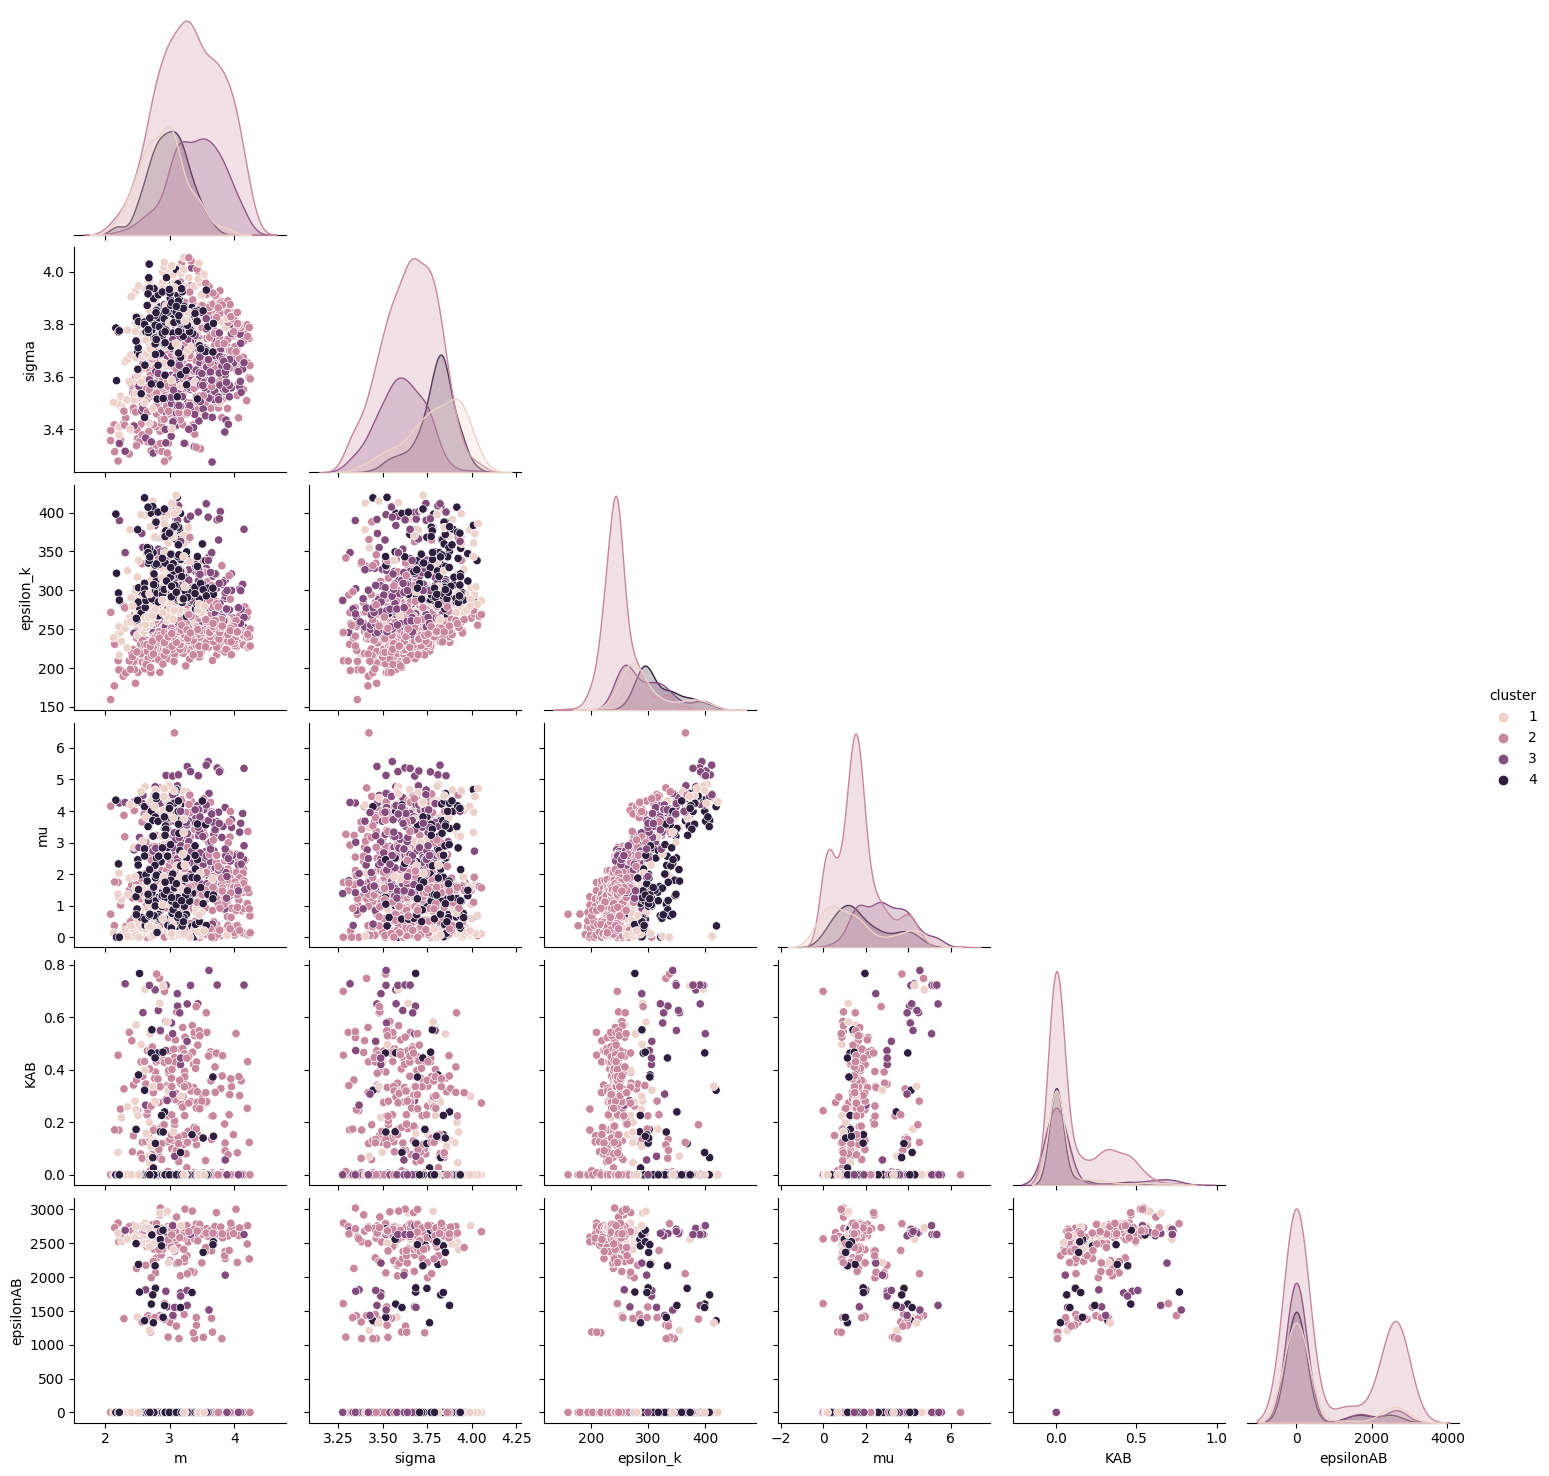

In [25]:
sns.pairplot(
    pure_filt,
    vars=output_columns,
    corner=True,
    hue="cluster"
)
plt.show()

In [6]:
import warnings
def umap_plot(ax, df, fps, n_neighbors=15, min_dist=0.1):

    warnings.filterwarnings('ignore')
    reducer = UMAP(
        random_state=0, 
        metric="jaccard",
        n_neighbors=n_neighbors,
        min_dist=min_dist,
    )
    X = reducer.fit_transform(fps)
    df = df.copy()
    df["X1"] = X[:,0]
    df["X2"] = X[:,1]
    for cluster, df_i in df.groupby("cluster"):
        ax.scatter(df_i["X1"], df_i["X2"], label=cluster)
    ax.legend()
    ax.tick_params(direction="in")

100%|█████████████████████████████████████████████| 16/16 [00:54<00:00,  3.39s/it]


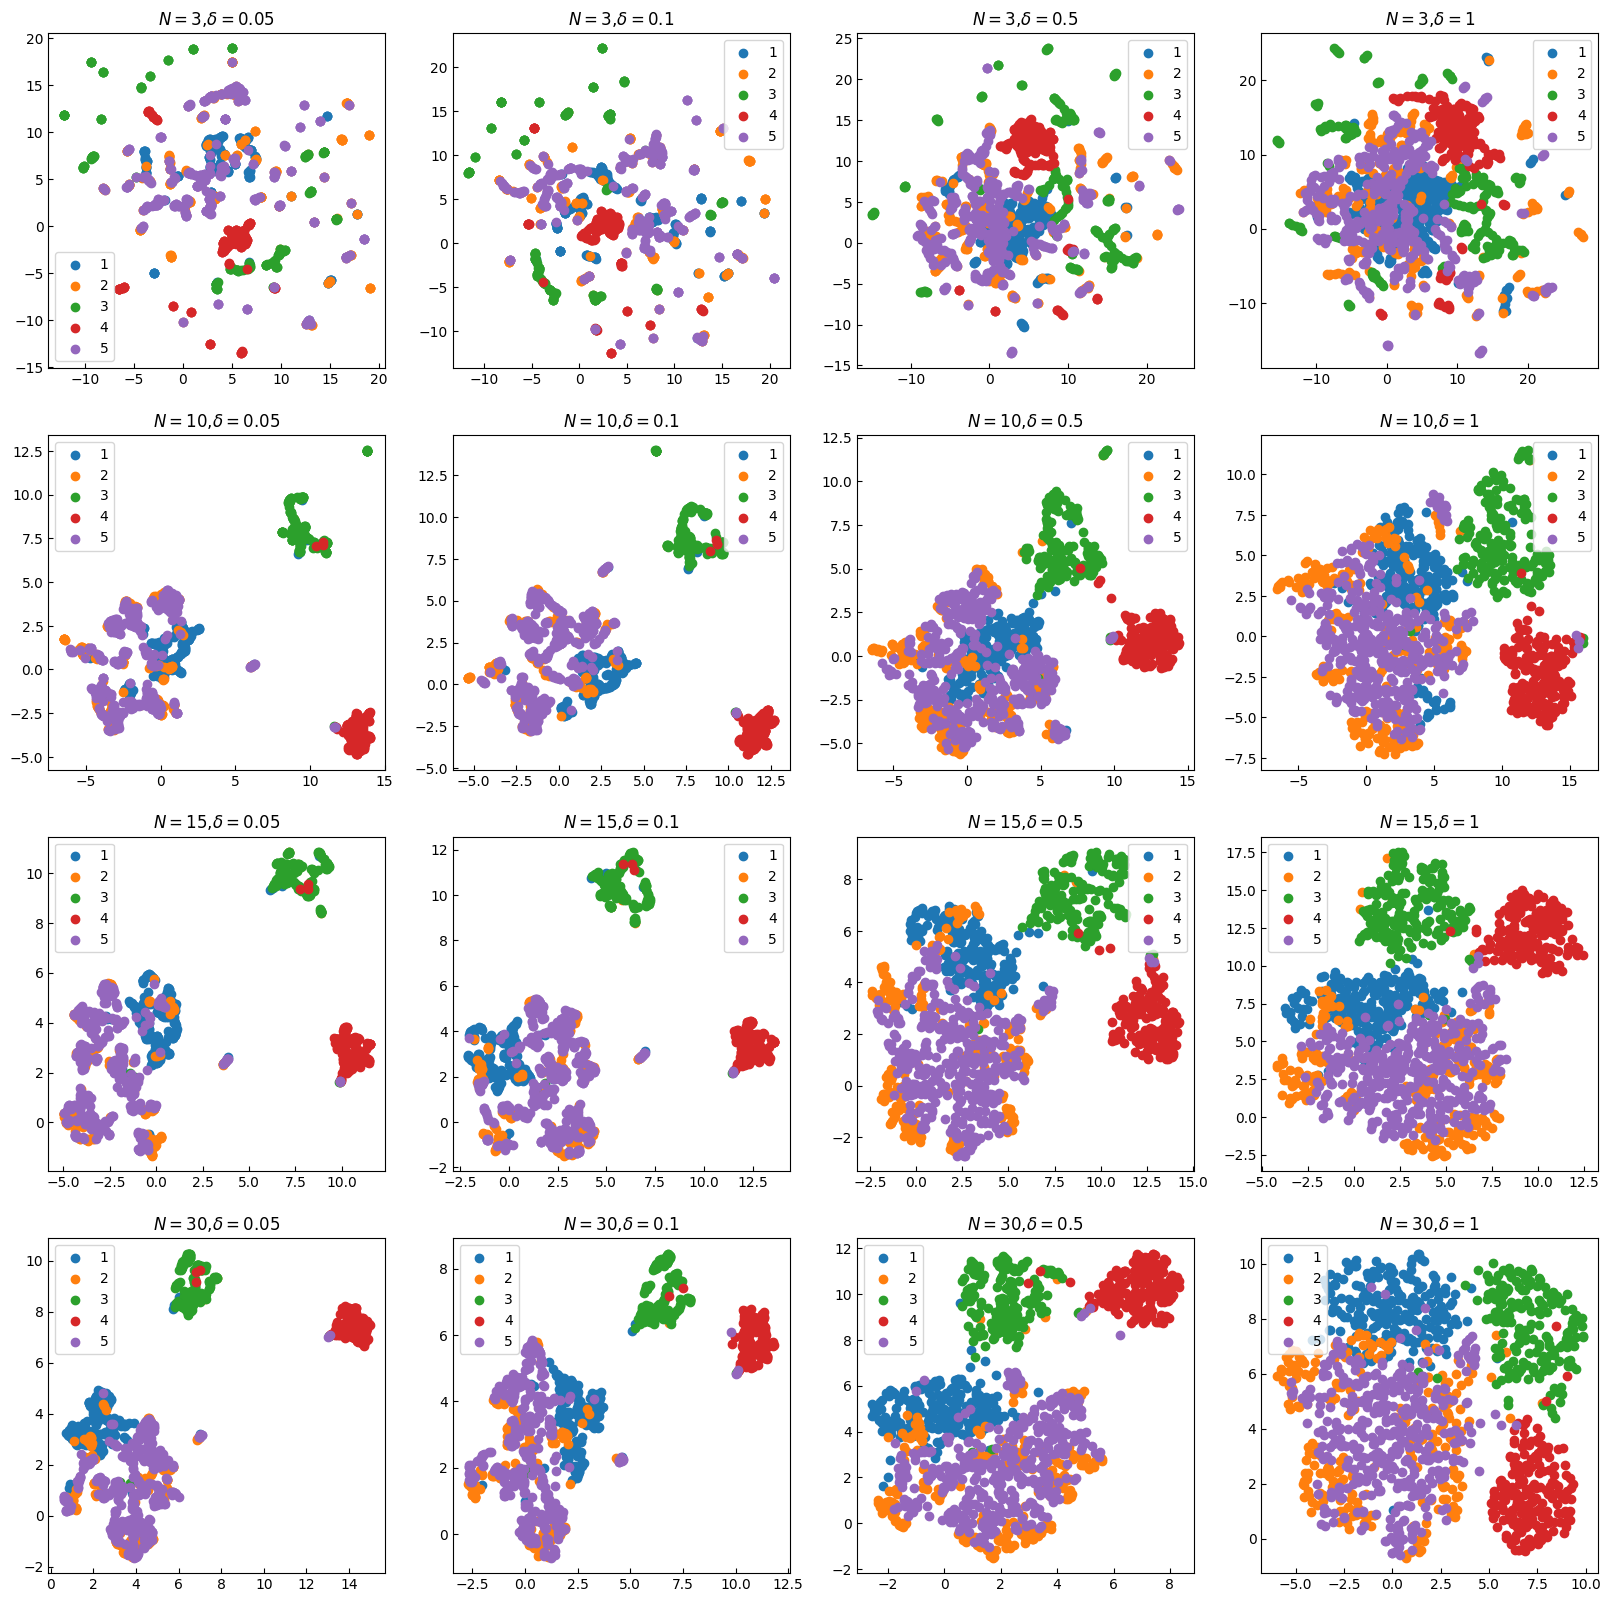

In [7]:
n_neighbors_list = [3,10,15, 30]
min_dist_list = [0.05, 0.1, 0.5, 1]
i = 1
fig = plt.figure(figsize=(5*len(n_neighbors_list),5*len(min_dist_list)))
n =len(n_neighbors_list)*len(min_dist_list)
with tqdm(total=n) as pbar:
    for n_neighbors in n_neighbors_list:
        for min_dist in min_dist_list:
            ax = fig.add_subplot(len(n_neighbors_list),len(min_dist_list), i)
            umap_plot(ax, pure, morgans, n_neighbors, min_dist)
            ax.set_title(r"$N=$" + f"{n_neighbors}," + r"$\delta=$" + f"{min_dist}")
            i+=1
            pbar.update(1)
fig.savefig(
    "../data/08_reporting/pure_component_morgan_fingerprints_cluster_umap_comparison.png",dpi=300
)

I like N=15, $\delta$=0.5

In [12]:
reducer = UMAP(random_state=0, metric="jaccard", n_neighbors=15, min_dist=0.5)
X = reducer.fit_transform(morgans)
pure["X1"] = X[:,0]
pure["X2"] = X[:,1]

2023-01-14 16:57:57,773 - py.warnings - WARNING - /Users/Kobi/Library/Caches/pypoetry/virtualenvs/dl4thermo-gYF7kwgA-py3.8/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(



In [ ]:
pure["Name"] = pure["Name"].astype(str).fillna("")
fig_scatter = px.scatter(
    pure,
    x="X1",
    y="X2",
    color='cluster',
    title='UMAP',
    hover_data={
        "m": ":.02f",
        "sigma":  ":.02f",
        "mu":  ":.02f",
        "epsilon_k":  ":.02f",
        "KAB":  ":.02f",
        "epsilonAB":  ":.02f",
        "X1": False,
        "X2": False,
    },
    labels={
        "m": "m",
        "sigma": r"$\sigma$",
        "mu": r"$\mu$",
        "epsilon_k": r"$\epsilon/k$",
        "KAB": r"$K_{AB}$",
        "epsilonAB": r"$\epsilon_{AB}$",
    },
    width=800,
    height=600
)
app_scatter = molplotly.add_molecules(
    fig=fig_scatter,
    df=pure,
    smiles_col='Smiles',
)
app_scatter.run_server(mode='inline', port=8002, height=1000)

In [6]:
<<<<<<< REMOTE CELL DELETED >>>>>>>
morgans = compute_fingerprints(pure["Smiles"], fingerprint_type='morgan')
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(morgans)
pure["cluster"] = kmeans.labels_ + 1

morgan fingerprints: 100%|█████████████████| 1258/1258 [00:00<00:00, 14065.28it/s]

2023-01-14 16:56:36,977 - py.warnings - WARNING - /Users/Kobi/Library/Caches/pypoetry/virtualenvs/dl4thermo-gYF7kwgA-py3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



In [6]:
import warnings
def umap_plot(ax, df, fps, n_neighbors=15, min_dist=0.1):

    warnings.filterwarnings('ignore')
    reducer = UMAP(
        random_state=0, 
        metric="jaccard",
        n_neighbors=n_neighbors,
        min_dist=min_dist,
    )
    X = reducer.fit_transform(fps)
    df = df.copy()
    df["X1"] = X[:,0]
    df["X2"] = X[:,1]
    for cluster, df_i in df.groupby("cluster"):
        ax.scatter(df_i["X1"], df_i["X2"], label=cluster)
    ax.legend()
    ax.tick_params(direction="in")

100%|█████████████████████████████████████████████| 16/16 [00:54<00:00,  3.39s/it]


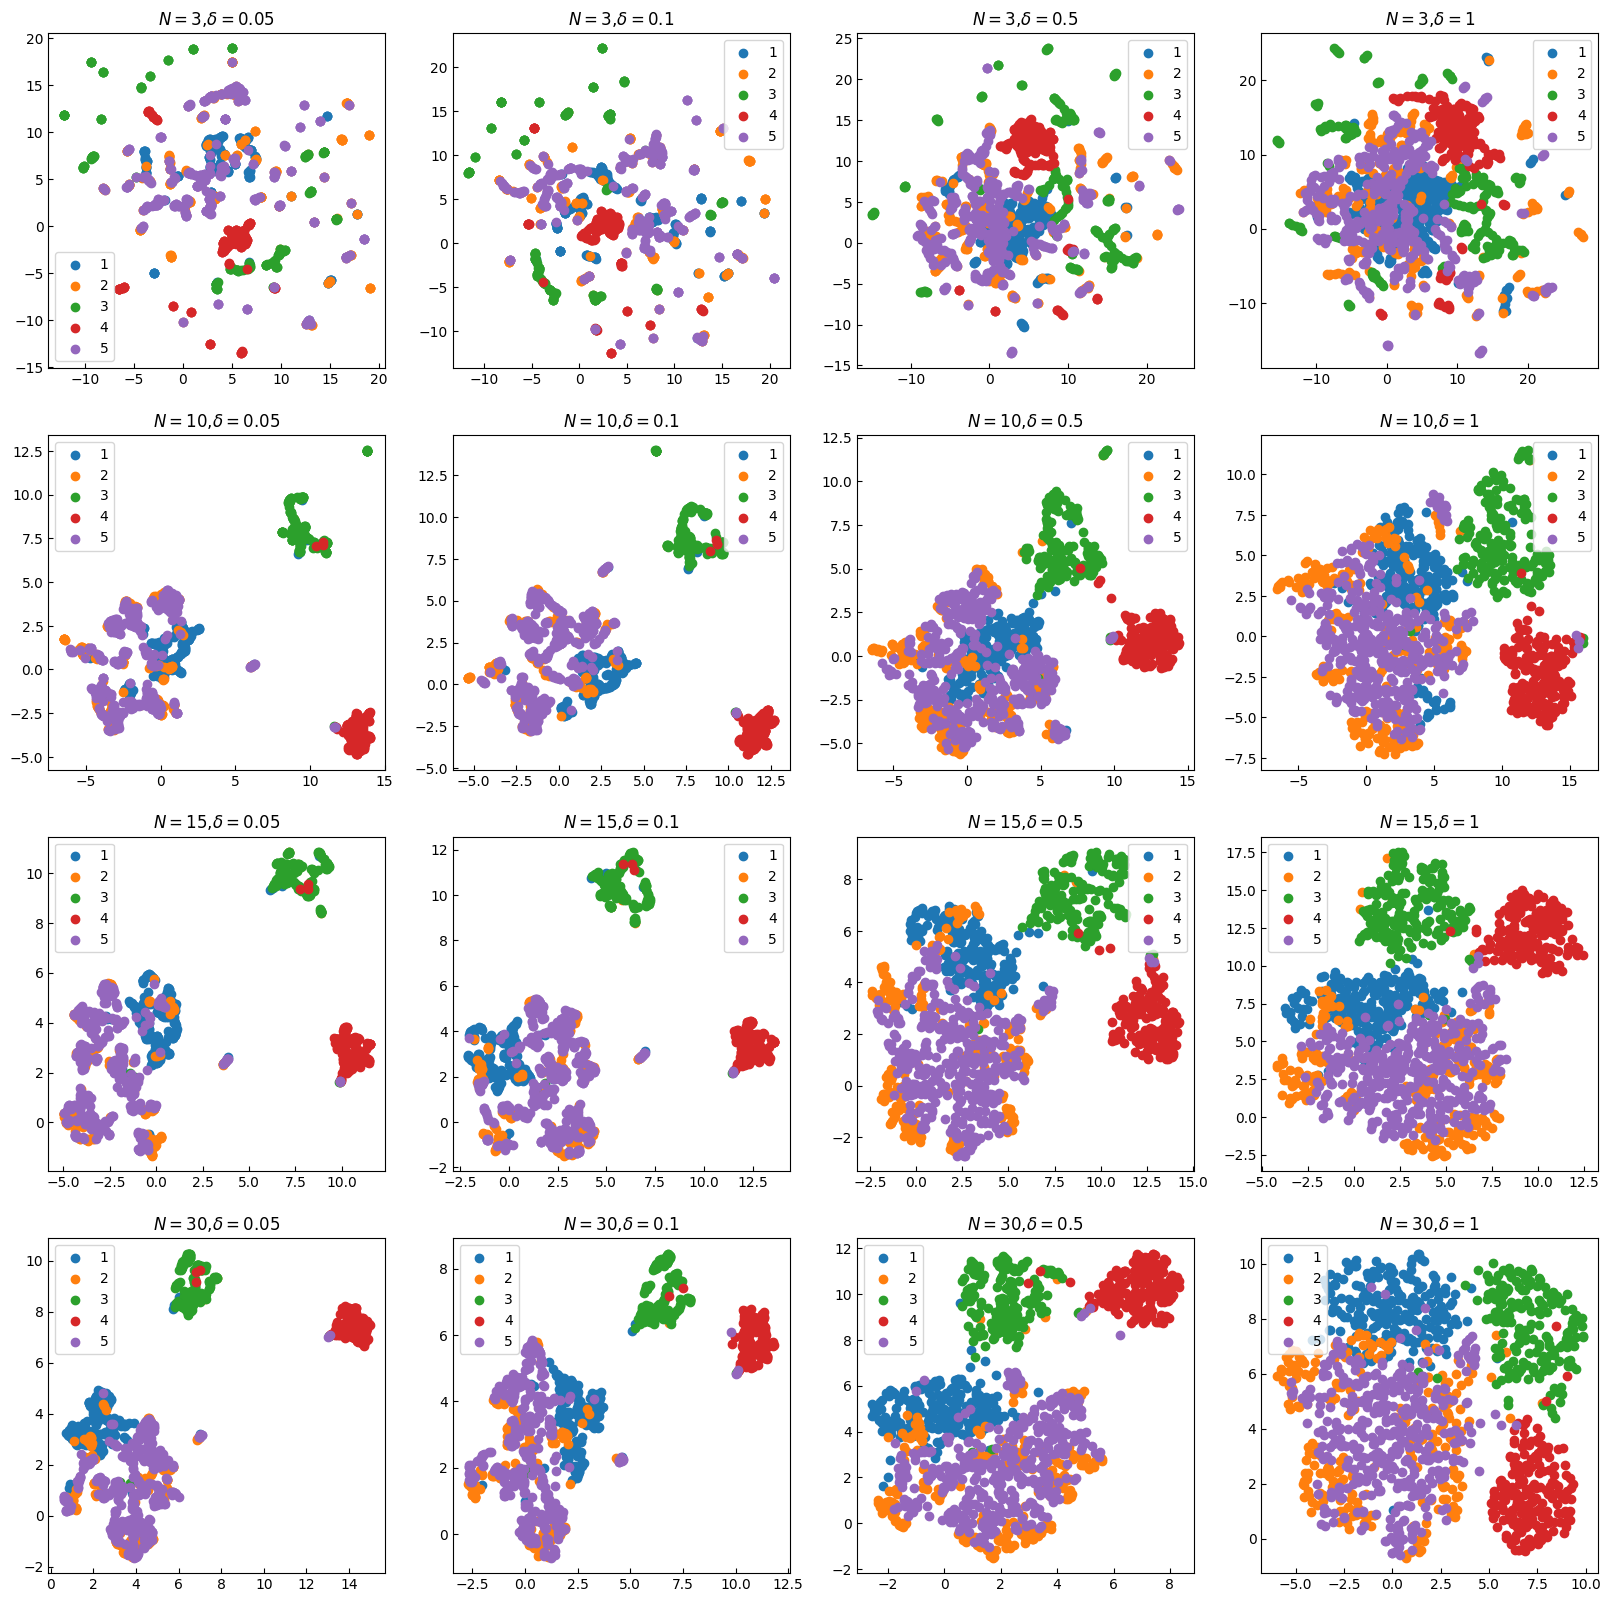

In [7]:
n_neighbors_list = [3,10,15, 30]
min_dist_list = [0.05, 0.1, 0.5, 1]
i = 1
fig = plt.figure(figsize=(5*len(n_neighbors_list),5*len(min_dist_list)))
n =len(n_neighbors_list)*len(min_dist_list)
with tqdm(total=n) as pbar:
    for n_neighbors in n_neighbors_list:
        for min_dist in min_dist_list:
            ax = fig.add_subplot(len(n_neighbors_list),len(min_dist_list), i)
            umap_plot(ax, pure, morgans, n_neighbors, min_dist)
            ax.set_title(r"$N=$" + f"{n_neighbors}," + r"$\delta=$" + f"{min_dist}")
            i+=1
            pbar.update(1)
fig.savefig(
    "../data/08_reporting/pure_component_morgan_fingerprints_cluster_umap_comparison.png",dpi=300
)

I like N=15, $\delta$=0.5

In [12]:
reducer = UMAP(random_state=0, metric="jaccard", n_neighbors=15, min_dist=0.5)
X = reducer.fit_transform(morgans)
pure["X1"] = X[:,0]
pure["X2"] = X[:,1]

2023-01-14 16:57:57,773 - py.warnings - WARNING - /Users/Kobi/Library/Caches/pypoetry/virtualenvs/dl4thermo-gYF7kwgA-py3.8/lib/python3.8/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(



In [ ]:
pure["Name"] = pure["Name"].astype(str).fillna("")
fig_scatter = px.scatter(
    pure,
    x="X1",
    y="X2",
    color='cluster',
    title='UMAP',
    hover_data={
        "m": ":.02f",
        "sigma":  ":.02f",
        "mu":  ":.02f",
        "epsilon_k":  ":.02f",
        "KAB":  ":.02f",
        "epsilonAB":  ":.02f",
        "X1": False,
        "X2": False,
    },
    labels={
        "m": "m",
        "sigma": r"$\sigma$",
        "mu": r"$\mu$",
        "epsilon_k": r"$\epsilon/k$",
        "KAB": r"$K_{AB}$",
        "epsilonAB": r"$\epsilon_{AB}$",
    },
    width=800,
    height=600
)
app_scatter = molplotly.add_molecules(
    fig=fig_scatter,
    df=pure,
    smiles_col='Smiles',
)
app_scatter.run_server(mode='inline', port=8002, height=1000)

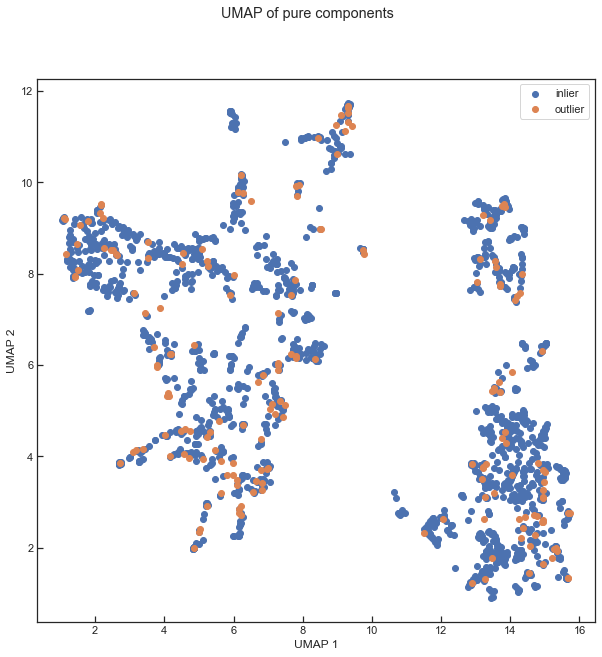

In [46]:
fig, ax = plt.subplots(1, figsize=(10,10))
for out, df_i in df_norm.groupby("outlier"):
    ax.scatter(df_i["X1"], df_i["X2"], label=out)
ax.legend()
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.tick_params(direction="in")
fig.suptitle("UMAP of pure components")
fig.savefig("../data/08_reporting/pure_component_parameters_umap.png", dpi=300)

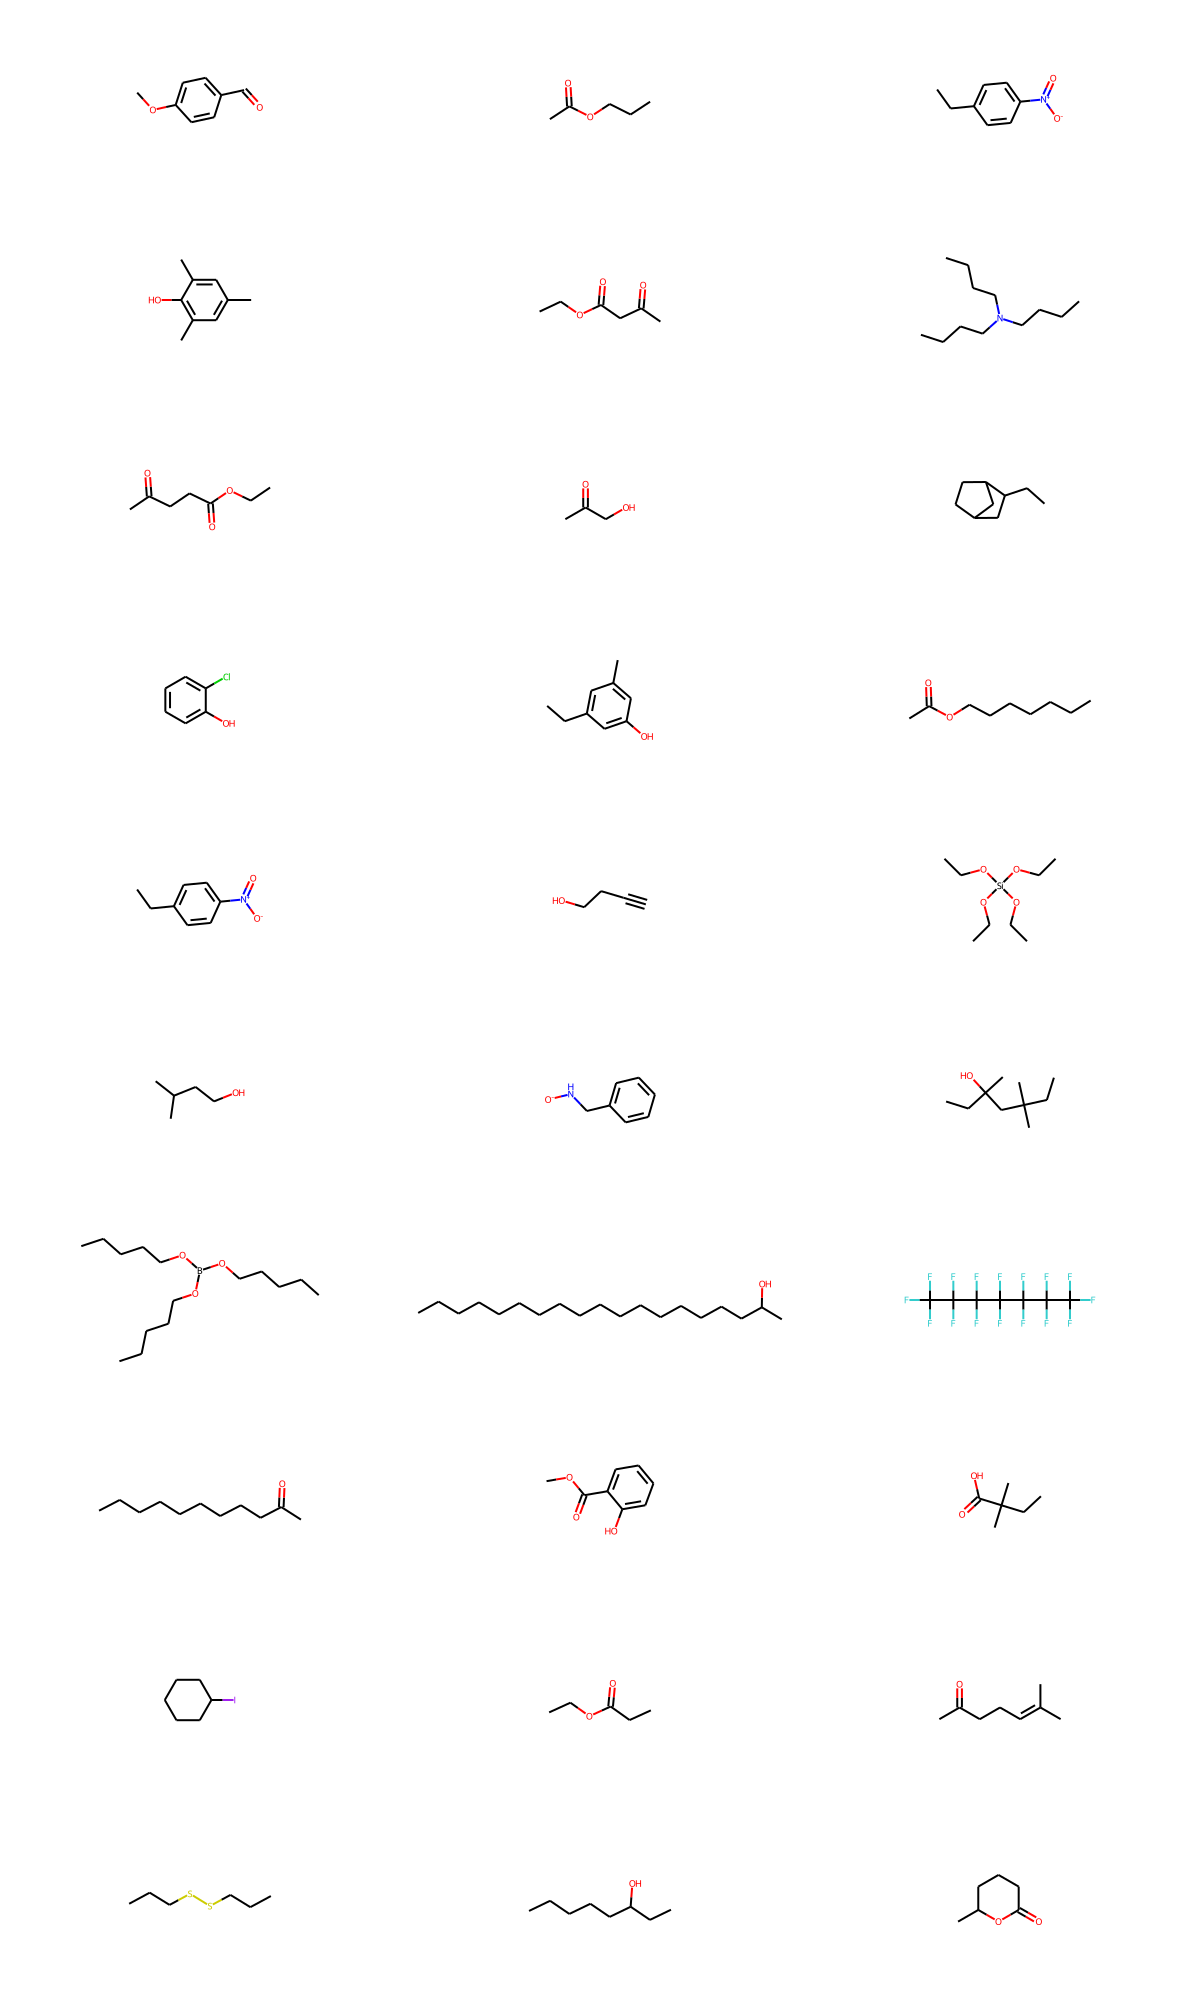

In [88]:
rng = default_rng(54)
n_samples = 30
outliers = df_norm[df_norm["outlier"]=="outlier"]
samples = rng.integers(0, len(outliers), size=n_samples)
img = Chem.Draw.MolsToGridImage(
    [
        Chem.MolFromSmiles(smiles) 
        for smiles in 
        outliers["smiles"].iloc[samples]
    ],
    molsPerRow=3,
    subImgSize=(400, 200),
    returnPNG=False,
)
img

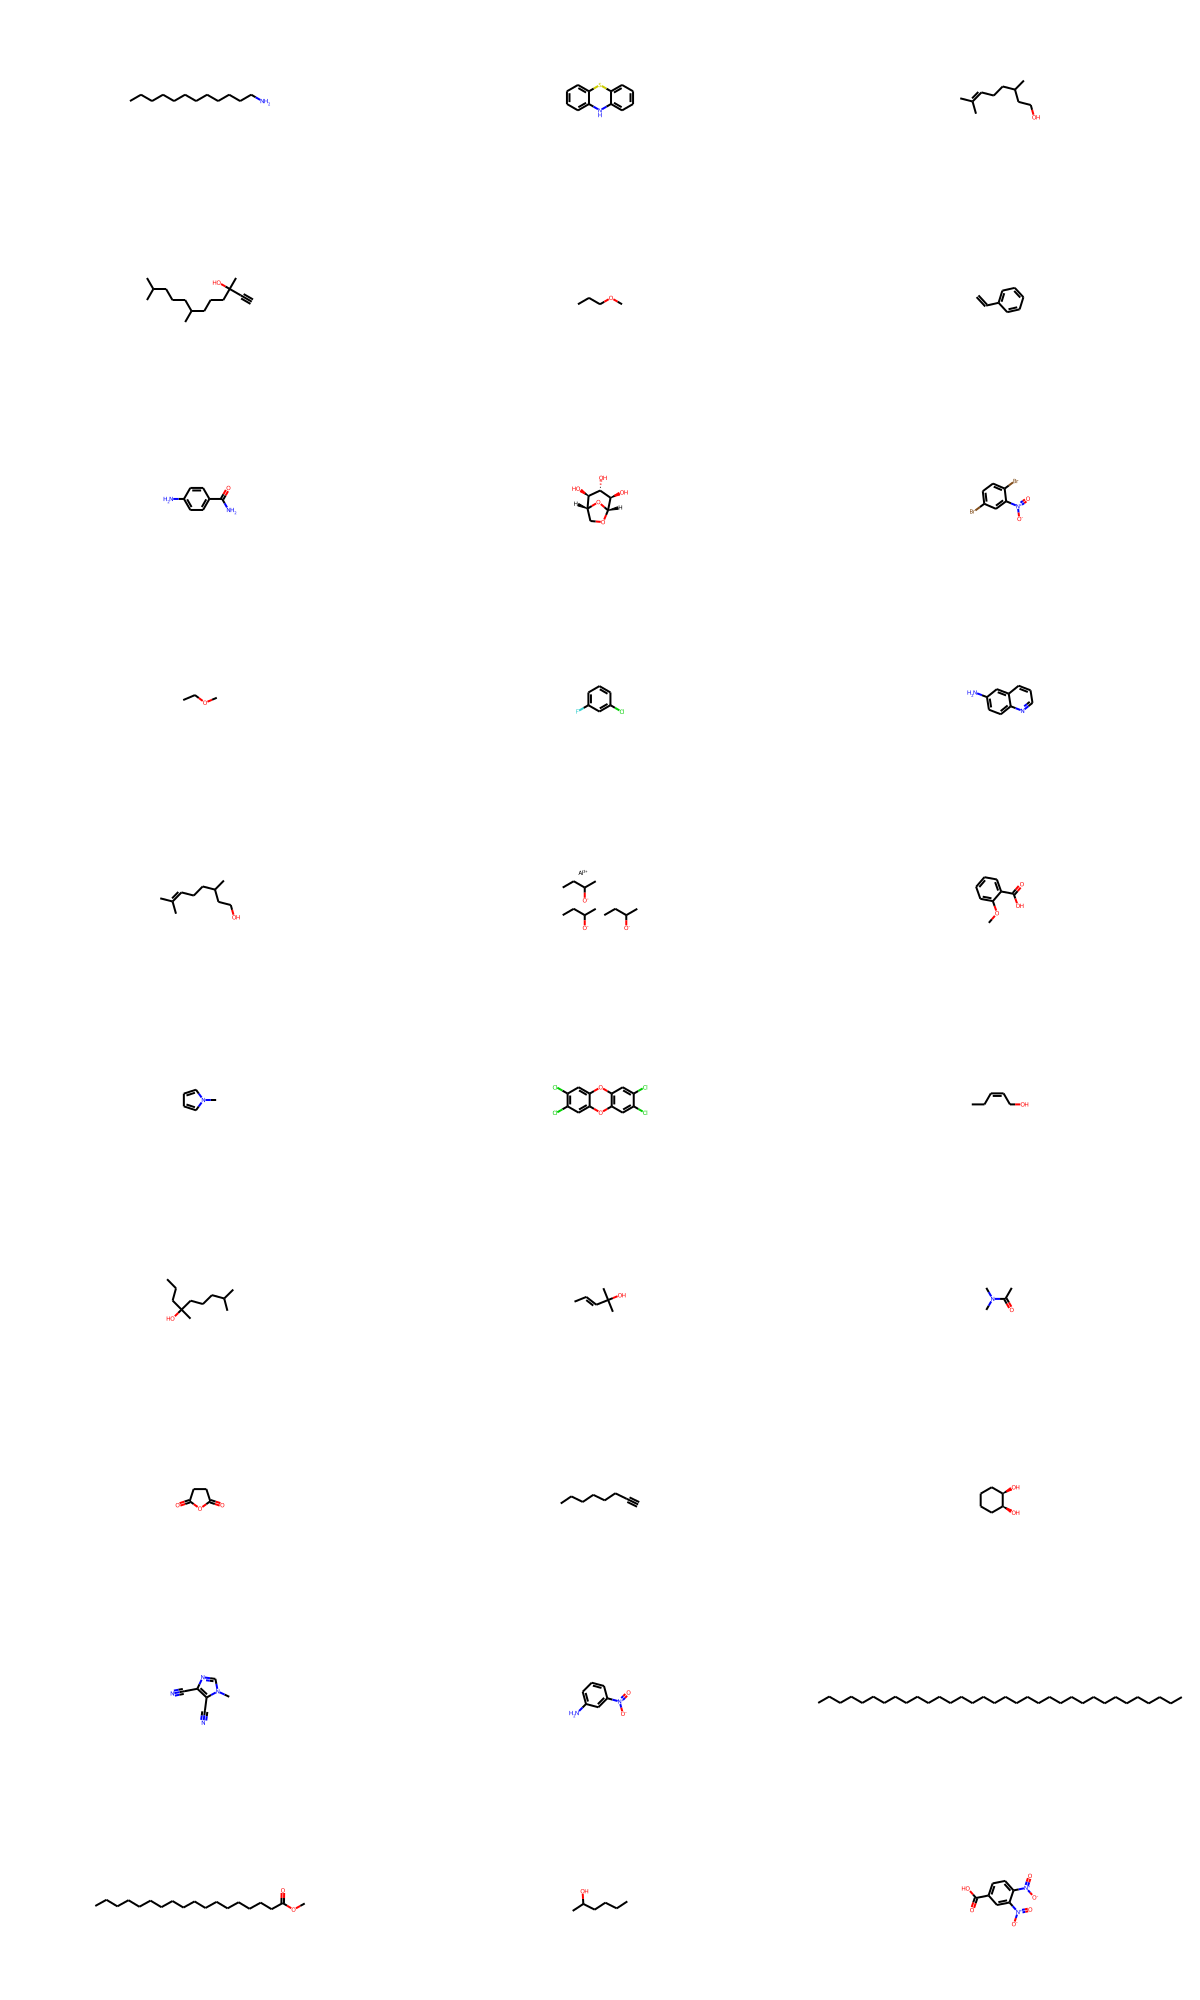

In [89]:
rng = default_rng(54)
n_samples = 30
inlier = df_norm[df_norm["outlier"]=="inlier"]
samples = rng.integers(0, len(inlier), size=n_samples)
img = Chem.Draw.MolsToGridImage(
    [
        Chem.MolFromSmiles(smiles) 
        for smiles in 
        inlier["smiles"].iloc[samples]
    ],
    molsPerRow=3,
    subImgSize=(400, 200),
    returnPNG=False,
)
img

### QM9 comparison

In [38]:
qm9 = catalog.load("qm9")

2022-12-07 10:49:49,549 - kedro.io.data_catalog - INFO - Loading data from 'qm9' (CSVDataSet)...


In [39]:
# smiles to same format
pure["Smiles"] = [Chem.MolToSmiles(Chem.MolFromSmiles(s)) for s in pure["Smiles"].tolist()]
qm9["Smiles"] = [Chem.MolToSmiles(Chem.MolFromSmiles(s)) for s in qm9["smiles"].tolist()]

In [40]:
# join
pure_qm9_overlap = pd.merge(pure, qm9, on="Smiles", how="inner")

In [41]:
pure_qm9_overlap

,Unnamed: 0.1,Unnamed: 0,Name,Smiles,Valid,sigma,m,epsilon_k,mu_x,Assoc_scheme,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,10,10,Ethyne,C#C,True,3.279874,1.525541,139.171288,0.000000,2B,...,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724
1,14,14,Hydrogen_cyanide,C#N,True,3.254300,1.498256,193.116787,3.038300,2B,...,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028
2,22,22,Formaldehyde,C=O,True,3.003592,1.724687,211.130326,2.336300,2B,...,0.026603,-114.483613,-114.480746,-114.479802,-114.505268,6.413,-358.756935,-360.512706,-362.291066,-340.464421
3,24,24,Methanol,CO,True,3.045343,1.868526,196.203356,1.690812,2B,...,0.051208,-115.679136,-115.675816,-115.674872,-115.701876,8.751,-481.106758,-484.355372,-487.319724,-450.124128
4,28,28,Ethane,CC,True,3.234204,1.974231,170.700851,0.000000,2B,...,0.074542,-79.764152,-79.760666,-79.759722,-79.787269,10.098,-670.788296,-675.710476,-679.860821,-626.927299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,1945,1945,3-Methyl-3-heptanol,CCCCC(C)(O)CC,True,3.873402,3.814483,253.899253,1.461423,2B,...,0.249013,-390.711392,-390.699263,-390.698319,-390.748829,44.541,-2427.030992,-2443.415880,-2458.828756,-2247.784301
667,1958,1958,Ethyl_3-hydroxybutyrate,CCOC(=O)CC(C)O,True,3.618763,3.861298,297.117611,2.794368,2B,...,0.179946,-461.412144,-461.401512,-461.400568,-461.449010,37.588,-1966.926333,-1978.918030,-1990.772930,-1826.922172
668,1961,1961,Cyclohexyl_formate,O=COC1CCCCC1,True,3.813151,3.238575,304.550346,2.286604,2B,...,0.183853,-424.280261,-424.271470,-424.270525,-424.315053,32.783,-2020.844416,-2033.991985,-2045.846257,-1879.794826
669,1962,1962,Monopropylene_glycol_methyl_ether_acetate,COC(C)COC(C)=O,True,3.579214,3.880840,275.879836,1.237614,2B,...,0.178487,-461.394216,-461.382938,-461.381994,-461.432899,38.008,-1955.676352,-1967.262678,-1979.117578,-1816.812375


In [44]:
# calculate diff in mu values and 
pure_qm9_overlap["mu_diff"] = pure_qm9_overlap["mu_x"] - pure_qm9_overlap["mu_y"]
mae_mu = np.mean(np.abs(pure_qm9_overlap["mu_diff"].to_numpy()))
print(f"Average mu difference of pcp calculations and qm9: {mae_mu:.4f}")

Average mu difference of pcp calculations and qm9: 0.2962


[]

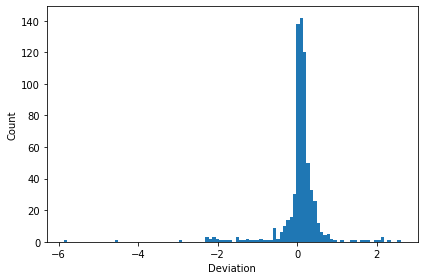

In [43]:
# plot distribution of mu deviations
fig, axs = plt.subplots(1, tight_layout=True)
axs.hist(pure_qm9_overlap["mu_diff"].to_numpy(), bins=100)
axs.set_xlabel("Deviation")
axs.set_ylabel("Count")
plt.plot()

## SEPP holdout

In [9]:
sepp_holdout = catalog.load("sepp_holdout_set")
dortmund = catalog.load("dortmund_base_pure_component_filtered")

2023-03-13 21:32:04,819 - kedro.io.data_catalog - INFO - Loading data from 'sepp_holdout_set' (CSVDataSet)...
2023-03-13 21:32:04,824 - kedro.io.data_catalog - INFO - Loading data from 'dortmund_base_pure_component_filtered' (ParquetDataSet)...


In [7]:
sepp_holdout["SMILES"] = sepp_holdout["SMILES"].apply(Chem.CanonSmiles)

In [12]:
sepp_holdout.merge(dortmund.drop_duplicates("smiles_1"), left_on="SMILES", right_on="smiles_1", how="left")

,Name,SMILES,Component,#DDB,T,P,Type,DEN,cas_number_1,name_1,alternative_name_1,smiles_1,status_1
0,propene,C=CC,Propylene,1055,203.42,32.757,Experimental Data,NaN,115-07-1,Propylene,Propene,C=CC,Include
1,n-pentanoic acid,CCCCC(=O)O,Pentanoic acid,324,459.15,101.325,Experimental Data,NaN,109-52-4,Pentanoic acid,Valeric acid,CCCCC(=O)O,Include
2,ethanal,CC=O,Acetaldehyde,1,250.15,13.732,Experimental Data,NaN,75-07-0,Acetaldehyde,Ethanal,CC=O,Include
3,cyclohexanone,O=C1CCCCC1,Cyclohexanone,250,373.55,21.198,Experimental Data,NaN,108-94-1,Cyclohexanone,Pimelic ketone,O=C1CCCCC1,Include
4,2-methyl-1-pentanol,CCCC(C)CO,2-Methyl-1-pentanol,977,368.15,13.799,Experimental Data,NaN,105-30-6,2-Methyl-1-pentanol,2-Methyl-1-pentanol,CCCC(C)CO,Include
5,3-ethylhexane,CCCC(CC)CC,3-Ethylhexane,3783,326.00,10.310,Experimental Data,NaN,619-99-8,3-Ethylhexane,3-Ethylhexan,CCCC(CC)CC,Include
6,1-pentene,C=CCCC,1-Pentene,257,273.15,32.171,Experimental Data,NaN,109-67-1,1-Pentene,alpha-n-Amylene,C=CCCC,Include
7,2-nonanone,CCCCCCCC(C)=O,2-Nonanone,1325,401.81,14.089,Experimental Data,NaN,821-55-6,2-Nonanone,2-Nonanon,CCCCCCCC(C)=O,Include
8,5-dimethylhexane,CC(C)CCC(C)C,"2,5-Dimethylhexane",1283,317.67,10.310,Experimental Data,NaN,592-13-2,"2,5-Dimethylhexane","2,5-Dimethylhexan",CC(C)CCC(C)C,Include
9,n-propylamine,CCCN,N-Propylamine,377,320.20,96.765,Experimental Data,NaN,107-10-8,N-Propylamine,1-Aminopropane,CCCN,Include
